In [1]:
import os
import cv2
import glob
import random
import pywt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as Kback
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Reshape, Dropout, Concatenate, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix

**Load dataset**

In [2]:
Train = []
Valid = []
Test = []

for x in os.walk('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'):
    for y in glob.glob(os.path.join(x[0], '*.jpg')):
        Train.append(y)
        
for x in os.walk('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'):
    for y in glob.glob(os.path.join(x[0], '*.jpg')):
        Valid.append(y)

for x in os.walk('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'):
    for y in glob.glob(os.path.join(x[0], '*.jpg')):
        Test.append(y)
        
print(len(Train),len(Valid), len(Test))

100000 20000 20000


In [ ]:
# Divided into train and test sets
X_train, Y_test = train_test_split(allImages, test_size = 0.2, random_state=35)

# Divided into train and validation sets
X_train, Y_val = train_test_split(X_train, test_size = 0.2, random_state=15)
print(len(X_train),len(Y_test),len(Y_val))

**Xception Model**

In [4]:
def build_model(input_shape):
    # Shared input layer
    input_tensor = Input(shape=input_shape)

    xception_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
    out = xception_model.output
    xception_out = tf.keras.layers.GlobalAveragePooling2D()(out)
    
    x1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation = 'relu')(input_tensor)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    x2 = tf.keras.layers.Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same')(x2)
    #y = tf.keras.layers.Flatten()(x4)
    y = tf.keras.layers.GlobalAveragePooling2D()(x2)
    # Concatenate the output of Xception and the last convolutional layer
    #concatenated = Concatenate()([xception_out, y])

    # MLP for binary classification
    mlp = Dense(1024, activation='relu')(y)
    mlp = tf.keras.layers.Dropout(0.5)(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dense(512, activation='relu')(mlp)
    mlp = tf.keras.layers.Dropout(0.5)(mlp)
    mlp = BatchNormalization()(mlp)
    mlp_output = Dense(2, activation='softmax')(mlp)

    # Create the final model'''
    model = Model(inputs=input_tensor, outputs = mlp_output)
    return model

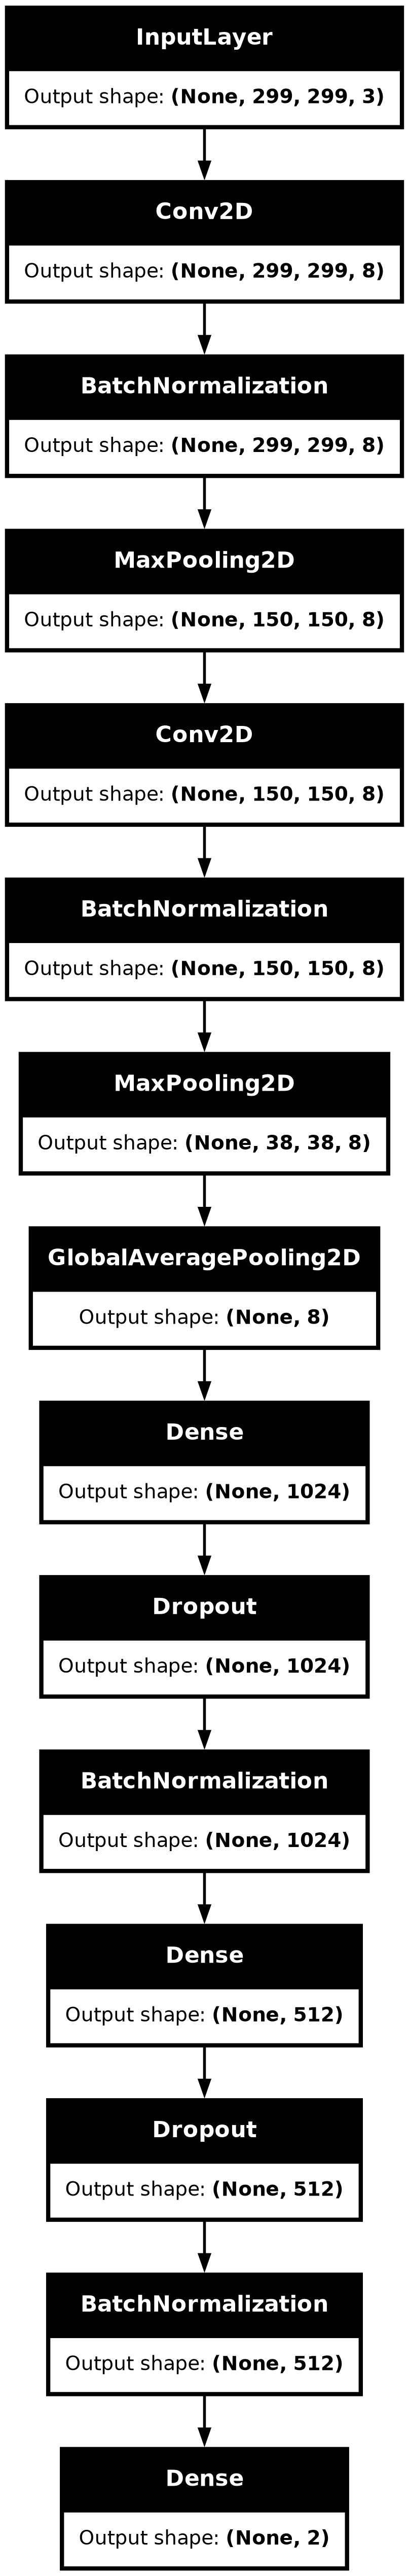

In [5]:
input_shape = (299, 299, 3)
model = build_model(input_shape)
plot_model(model, show_shapes=True, to_file='model1.png')

In [ ]:
def build_efficientnet_b0_model(input_shape):
    # Load pre-trained EfficientNet-B0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model on top
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    return output

In [ ]:
input_shape = (299, 299, 3)
model2 = build_efficientnet_b0_model(input_shape)
#plot_model(model, show_shapes=True, to_file='model1.png')

**Convolution Model**

In [ ]:
    model2 = Sequential()
    
    model2.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (299, 299, 3)))
    model2.add(MaxPooling2D((2,2)))
    
    model2.add(Conv2D(32, (3,3), activation = 'relu'))
    model2.add(MaxPooling2D((2,2)))
    
    model2.add(Conv2D(32, (3,3), activation = 'relu'))
    model2.add(MaxPooling2D((2,2)))

    model2.add(Flatten())
    model2.add(Dense(64, activation = 'relu'))
    model2.add(Dense(64, activation = 'relu'))
    
    model2.add(Dense(2, activation = 'softmax'))
    
    #plot_model(model2, to_file='model2.png')

**Concatenation**

In [ ]:
x = Concatenate()([model1.output,model2.output])
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(2, activation='softmax', name='output')(x)
model5 = Model(inputs=[model1.input, model2.input], outputs=output)
#plot_model(net_model, to_file='model.png')

**Reading Images**

In [7]:
def color_to_luminance_and_wavelet(image_path):
    # Read the color image
    original_image = cv2.imread(image_path)

    # Convert the color image to luminance (grayscale)
    luminance_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Resize the luminance image to ensure its size is compatible with wavelet transform
    rows, cols = luminance_image.shape
    if rows % 2 != 0:
        rows -= 1
    if cols % 2 != 0:
        cols -= 1
    luminance_image = cv2.resize(luminance_image, (cols, rows))

    # Apply Haar wavelet transform
    coeffs = pywt.dwt2(luminance_image, 'haar')

    # Extract LL (approximation) coefficients
    LL, (_, _, _) = coeffs

    # Resize LL coefficients to match the size of the luminance image
    LL = cv2.resize(LL, (cols, rows))

    # Subtract LL coefficients from the luminance image to get high-frequency residual
    high_frequency_residual = luminance_image.astype(int) - LL.astype(int)
    
    uint8_HFR = high_frequency_residual.astype(np.uint8)
    
    # Convert BGR image to HSV
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

    # Extract individual components
    h, _, _ = cv2.split(hsv_image)
    
    h = cv2.resize(h, (cols, rows))
        
    #print(original_image.shape, h.shape, luminance_image.shape, uint8_HFR.shape)
    #print('HFR', high_frequency_residual.shape)
    mergedImage = cv2.merge([h, luminance_image, uint8_HFR])
    
    return mergedImage

In [8]:
def image_generator(files, batch_size, resize=None):
    while True:
        batch_paths  = np.random.choice(a = files, size = batch_size)
        batch_x = []
        batch_y = [] 
          
        for input_path in batch_paths:
            input = get_input(input_path)
            output = get_output(input_path)
            if resize is not None:
                input = cv2.resize(input, resize)
            batch_x.append(input)
            batch_y.append(output)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        yield batch_x, batch_y

In [9]:
def get_input(path):
    #img = cv2.imread(path)
    img = color_to_luminance_and_wavelet(path)
    input = cv2.resize(img, (299, 299))
    return(input)
 
def get_output(path):
    #Considered fake = 1 and real = 0
    labaF = [1,0]
    labaT = [0,1]
    folder_path = os.path.dirname(path)
    label = os.path.basename(folder_path)  # Extracting folder name instead of file name
    if 'fake' == label:
        return labaF
    else:
        return labaT

**Matrices**

In [10]:
def f1_score(y_true, y_pred):
    y_true = Kback.cast(y_true, 'float32') 
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      tf.metrics.Precision(name='precision'),
      tf.metrics.Recall(name='recall'),
      tf.metrics.AUC(name='auc'),
      f1_score
]

In [9]:
#model = build_model((299,299,3))  
# Compile the model
optimizer = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

#EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(image_generator(Train, batch_size = 32),
                    epochs = 100,
                    steps_per_epoch = 40,
                    validation_data = image_generator(Valid, batch_size = 32),
                    validation_steps = 15,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/100


2024-04-04 04:51:33.624848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.14422, expected 3.389
2024-04-04 04:51:33.624915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.90007, expected 5.14485
2024-04-04 04:51:33.624925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.30012, expected 5.5449
2024-04-04 04:51:33.624933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.23722, expected 5.482
2024-04-04 04:51:33.624940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.08366, expected 5.32844
2024-04-04 04:51:33.624948: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.04657, expected 5.29135
2024-04-04 04:51:33.624956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 5.75857, expected 5.00335
2024-04-04 04:51:33.624963: E external/local_xla/xla/service

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5193 - auc: 0.5261 - f1_score: 0.5193 - loss: 1.0040 - precision: 0.5193 - recall: 0.5193
Epoch 1: val_accuracy improved from -inf to 0.60625, saving model to model.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 705ms/step - accuracy: 0.5201 - auc: 0.5272 - f1_score: 0.5201 - loss: 1.0027 - precision: 0.5201 - recall: 0.5201 - val_accuracy: 0.6062 - val_auc: 0.6215 - val_f1_score: 0.6062 - val_loss: 0.6751 - val_precision: 0.6062 - val_recall: 0.6062
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6147 - auc: 0.6622 - f1_score: 0.6147 - loss: 0.8349 - precision: 0.6147 - recall: 0.6147
Epoch 2: val_accuracy improved from 0.60625 to 0.61250, saving model to model.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 574ms/step - accuracy: 0.6154 - auc: 0.6629 - f1_score: 0.6154 - loss: 0.8341 - precision: 0.6154 - recall: 0.6154 - val_accuracy: 0.6125 - val_auc: 0.6641 - val_f1_score: 0.6125 - val_loss: 0.6538 - val_precision: 0.

**Training**

In [1]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc']
              )
#history.history['precision'], history.history['val_precision'],
 #              history.history['recall'], history.history['val_recall'],
  #             history.history['f1_score'], history.history['val_f1_score']

NameError: name 'history' is not defined

**Test**

In [11]:
def test_image_generator(files):

    batch_paths = files
    batch_x = []
    batch_y = []

    for input_path in batch_paths:
        input = get_input(input_path)
        output = get_output(input_path)
#         if resize is not None:
#             input = cv2.resize(input, resize)
        batch_x.append(input)
        batch_y.append(output)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    return batch_x, batch_y

In [12]:
from keras.models import load_model
x_test,y_test = test_image_generator(Test)

In [ ]:
print(len(x_test))
print(len(y_test))

In [13]:
model = build_model((299,299,3))  # You need to define the model creation function
optimizer = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)

# Load the saved weights
model.load_weights('/kaggle/working/model.weights.h5')
model.evaluate(x_test,y_test,batch_size=1)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 346 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
2024-04-04 05:41:51.652221: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 89425: 3.67597, expected 3.20294
2024-04-04 05:41:51.652282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 89449: 3.05765, expected 2.58462
2024-04-04 05:41:51.652298: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 89450: 3.21875, expected 2.74572
2024-04-04 05:41:51.652306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 89456: 2.6257, expected 2.15267
2024-04-04 05:41:51.652314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 89457: 3.67345, expected 3.20042
2024-04-04 05:41:51.652321: E ex

   16/20000 ━━━━━━━━━━━━━━━━━━━━ 3:32 11ms/step - accuracy: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - loss: 0.0021 - precision: 1.0000 - recall: 1.0000    

I0000 00:00:1712209314.185976     273 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 211s 10ms/step - accuracy: 0.9960 - auc: 0.9999 - f1_score: 0.9960 - loss: 0.0119 - precision: 0.9960 - recall: 0.9960


[0.017377445474267006,
 0.994350016117096,
 0.9998388290405273,
 0.9943498969078064,
 0.994350016117096,
 0.994350016117096]

2024-04-04 05:46:05.458333: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.14422, expected 3.389
2024-04-04 05:46:05.458393: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.90007, expected 5.14485
2024-04-04 05:46:05.458408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.30012, expected 5.5449
2024-04-04 05:46:05.458436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.23722, expected 5.482
2024-04-04 05:46:05.458448: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.08366, expected 5.32844
2024-04-04 05:46:05.458460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.04657, expected 5.29135
2024-04-04 05:46:05.458471: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 5.75857, expected 5.00335
2024-04-04 05:46:05.458482: E external/local_xla/xla/service

625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step


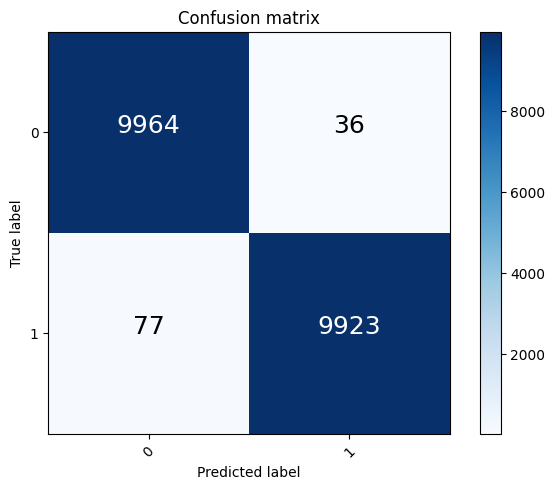

In [14]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontsize=18):
    """ 
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True. 
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)  # Set fontsize here

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Rest of your code...

# Example usage:
Y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2), fontsize=18)